In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-17 16:33:18.156661: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-17 16:33:18.743253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:5e:00.0
2024-07-17 16:33:18.743551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-17 16:33:18.745319: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-17 16:33:18.746712: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-17 16:33:18.747072: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-17 16:33:18.748907: I tensorflow/stream_executor

In [4]:
#Reading files into a log
import sys
import logging

nblog = open("nb_tl.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [5]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
class ConvScaleShift(keras.layers.Layer):
    def __init__(self, filters, kernel_size, trable = False, **kwargs):
        super(ConvScaleShift, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', activation = 'relu')
        self.shift = self.add_weight(name='shift', shape=(filters,), initializer='zeros', trainable=True)
        self.scale = self.add_weight(name='scale', shape=(filters,), initializer='ones', trainable=True)
        self.trable = trable
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shift': self.shift,
            'scale': self.scale,
            'trable': self.trable,
        })
        return config
    # Defines the computation
    def call(self, inputs):
        x = self.conv(inputs)
        if self.trable == False:
            return x
        else:
            return self.scale*x + self.shift

In [16]:
#Defining the CWoLA model
def CWoLA(p_i, trable = False):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    
    cnn = keras.Sequential([
        ConvScaleShift(64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        ConvScaleShift(64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        ConvScaleShift(128, (3,3), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        ConvScaleShift(128, (3,3), trable = trable),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [ ]:
#Extracting the data for pretraining
n_train_sr_bkg = 125000
n_train_sr_signal = 125000
files = ['id1','id5', 'id20', 'id30', 'id40', 'id50', 'dd1', 'dd5', 'id10', 'dd20', 
         'dd30', 'dd40', 'dd50'] #Notice that there is no dd10 file
rng = np.random.default_rng(seed=42)
for p_1 in [25, 50, 75]:
    bkg_sr_jet_1 = np.load(f'm_background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'm_background_images_sr_{p_1}_jet_2.npy')
    #First jet, background, SR
    bkg_train_1 = bkg_sr_jet_1[0:n_train_sr_bkg]
    #Second jet, background, SR
    bkg_train_2 = bkg_sr_jet_2[0:n_train_sr_bkg]
    
    bkg_train_1 = bkg_train_1.reshape((np.shape(bkg_train_1)[0], p_1, p_1, 1))
    bkg_train_2 = bkg_train_2.reshape((np.shape(bkg_train_2)[0], p_1, p_1, 1))
    bkg_train_label = np.zeros(np.shape(bkg_train_1)[0], dtype = int)
    
    signal_sr_jet_1_total = []
    signal_sr_jet_2_total = []
    for file in files:
        s1 = np.load(f'{file}_sr_{p_1}_jet_1.npy')[0:10000]
        s2 = np.load(f'{file}_sr_{p_1}_jet_2.npy')[0:10000]
        for idx, signal_sr_jet_1 in enumerate(s1): 
            signal_sr_jet_1_total.append(s1[idx])
            signal_sr_jet_2_total.append(s2[idx])
    signal_sr_jet_1_total = np.array(signal_sr_jet_1_total)
    signal_sr_jet_2_total = np.array(signal_sr_jet_2_total)
    
    signal_sr_jet_1_total = signal_sr_jet_1_total.reshape(np.shape(signal_sr_jet_1_total)[0], p_1, p_1, 1)
    signal_sr_jet_2_total = signal_sr_jet_2_total.reshape(np.shape(signal_sr_jet_2_total)[0], p_1, p_1, 1)
    
    
    indices = rng.permutation(np.shape(signal_sr_jet_1_total)[0])
    
    signal_sr_jet_1_total = signal_sr_jet_1_total[indices]
    signal_sr_jet_2_total = signal_sr_jet_2_total[indices]
    
    signal_train_1 = signal_sr_jet_1_total[0:n_train_sr_signal]
    signal_train_2 = signal_sr_jet_2_total[0:n_train_sr_signal]
    
    signal_train_label = np.ones(np.shape(signal_train_1)[0], dtype = int)
    
    x_train_1 = np.concatenate((signal_train_1, bkg_train_1))
    x_train_2 = np.concatenate((signal_train_2, bkg_train_2))
    y_train = np.concatenate((signal_train_label, bkg_train_label))
        
    #Mix up the samples
    indices_2 = rng.permutation(np.shape(y_train)[0])
        
    x_train_1 = x_train_1[indices_2]
    x_train_2 = x_train_2[indices_2]
    y_train = y_train[indices_2]    
    
    cwola = CWoLA(p_1)
    loss_object = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate = 1e-3)
    cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
    cwola.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_initial_dd10_{p_1}')
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights=True)
    history = cwola.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
    cwola.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_dd10_{p_1}')

Train on 200000 samples, validate on 50000 samples
Epoch 1/1000
200000/200000 [==============================] - 14s 70us/sample - loss: 0.3276 - accuracy: 0.8551 - val_loss: 0.2665 - val_accuracy: 0.8855
Epoch 2/1000
200000/200000 [==============================] - 13s 64us/sample - loss: 0.2696 - accuracy: 0.8855 - val_loss: 0.2610 - val_accuracy: 0.8876
Epoch 3/1000
200000/200000 [==============================] - 13s 64us/sample - loss: 0.2618 - accuracy: 0.8887 - val_loss: 0.2533 - val_accuracy: 0.8916
Epoch 4/1000
200000/200000 [==============================] - 13s 65us/sample - loss: 0.2546 - accuracy: 0.8923 - val_loss: 0.2468 - val_accuracy: 0.8934
Epoch 5/1000
200000/200000 [==============================] - 13s 64us/sample - loss: 0.2523 - accuracy: 0.8926 - val_loss: 0.2480 - val_accuracy: 0.8958
Epoch 6/1000
200000/200000 [==============================] - 13s 64us/sample - loss: 0.2486 - accuracy: 0.8947 - val_loss: 0.2446 - val_accuracy: 0.8942
Epoch 7/1000
200000/20000

In [27]:
cwola.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

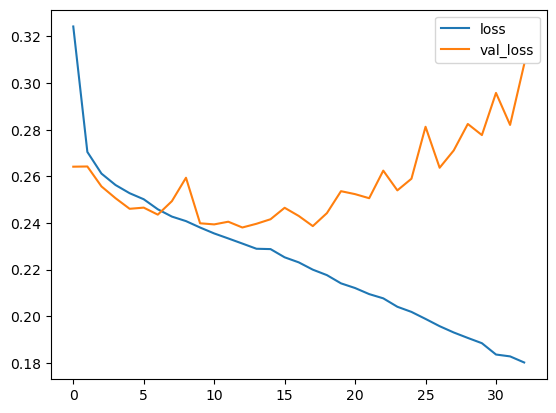

In [22]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

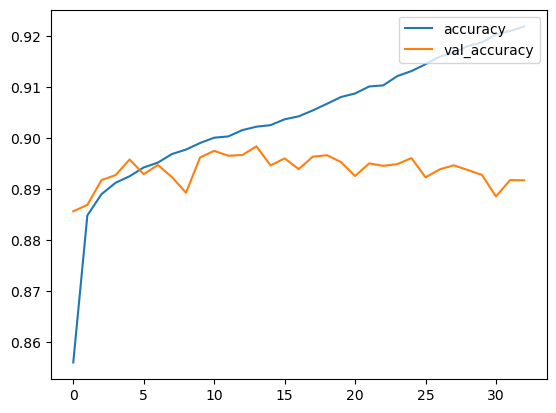

In [23]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [28]:
new_cwola = CWoLA(25, trable = True)
new_cwola.load_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_initial_dd10_{p_1}')


In [26]:
new_cwola.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [11]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

In [168]:
loaded_model = keras.models.load_model('pt_dd10_25.keras')

In [ ]:
initial_model = keras.models.load_model('pt_initial_dd10_25.keras')

In [170]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [171]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [172]:
loaded_model.trainable = False

In [43]:
print(cwola.layers[4].weights)

[<tf.Variable 'shift:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'scale:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'sequential_10/conv_scale_shift_20/conv2d_20/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
array([[[[ 0.01114146, -0.00054175,  0.02771809, ...,  0.00644149,
           0.00301851, -0.04814416]],

        [[-0.00246558, -0.02887559,  0.0596197 , ...,  0.02131684

In [44]:
print(cwola.layers[5].weights)

[<tf.Variable 'sequential_11/dense_20/kernel:0' shape=(1152, 128) dtype=float32, numpy=
array([[ 0.0141489 ,  0.08757062,  0.01885533, ...,  0.05162324,
        -0.00044119,  0.03995743],
       [ 0.09565278, -0.12674803,  0.04668333, ..., -0.07953626,
        -0.08850586,  0.09998466],
       [ 0.02065177, -0.05433097, -0.01092156, ..., -0.06529733,
         0.07160035,  0.06609359],
       ...,
       [-0.06971131, -0.03347652, -0.0661691 , ...,  0.03764331,
        -0.05056041,  0.06442278],
       [ 0.05344781,  0.05223055,  0.03656368, ..., -0.04453492,
        -0.04776639, -0.0560169 ],
       [ 0.03410593,  0.03541521, -0.09890695, ..., -0.13216387,
        -0.13213328, -0.12097926]], dtype=float32)>, <tf.Variable 'sequential_11/dense_20/bias:0' shape=(128,) dtype=float32, numpy=
array([-0.06826359,  0.08956084, -0.09667366, -0.03855992, -0.0189303 ,
       -0.00776841, -0.03980596, -0.07778458, -0.01601255, -0.02330212,
       -0.02789963, -0.02270724, -0.02277459, -0.00925469,

In [175]:
initial_weights = initial_model.layers[5].get_weights()
loaded_model.layers[5].set_weights(initial_weights)

In [176]:
print(loaded_model.layers[5].weights[0])

<tf.Variable 'sequential_5_9/dense_8/kernel:0' shape=(1152, 128) dtype=float32, numpy=
array([[ 0.04151135, -0.00030435, -0.01772699, ..., -0.02740256,
        -0.02138304, -0.01782336],
       [ 0.04094961,  0.05507887,  0.02192558, ...,  0.01142774,
         0.06550565, -0.03992231],
       [-0.06440324,  0.0638316 ,  0.04577684, ...,  0.00208545,
        -0.05588841, -0.01210831],
       ...,
       [ 0.0307514 , -0.01207008, -0.06143984, ..., -0.04826026,
         0.03134148,  0.00919251],
       [ 0.05978832,  0.00203153, -0.02276526, ..., -0.03255004,
        -0.03657148,  0.01606582],
       [-0.05766067,  0.06299955, -0.0452524 , ...,  0.05907474,
        -0.00846294,  0.00063005]], dtype=float32)>


In [31]:
# Fine-tuning on data
n_train_sr_bkg = 50000
n_train_sr_bkg_ft = 25000
mean_results = []
std_results = []
n_test_sr_bkg = 20000
for p_1 in [25]:#[25,50,75]:
    rng = np.random.default_rng(seed=42)
    os.chdir('/home/manhducnmd/pp_dijet/Model_results')    
    loaded_model = CWoLA(p_1, trable = False)   
    redundant_model = CWoLA(p_1, trable = False)
    loaded_model.load_weights(f'weights_pt_dd10_{p_1}') 
    redundant_model.load_weights(f'weights_pt_initial_dd10_{p_1}') 
    loaded_model.layers[5].set_weights(redundant_model.layers[5].get_weights())    
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')   
    
    bkg_sr_jet_1 = np.load(f'background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'background_images_sb_{p_1}_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg_ft = int(np.round(n_train_sr_bkg_ft*sb_sr_bkg))
    #First jet, background, SR
    bkg_pretrain_sr_1 = bkg_sr_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SR
    bkg_pretrain_sr_2 = bkg_sr_jet_2[0:-n_test_sr_bkg]
    #First jet, background, SB
    bkg_pretrain_sb_1 = bkg_sb_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SB
    bkg_pretrain_sb_2 = bkg_sb_jet_2[0:-n_test_sr_bkg]
    
    signal_sr_jet_1 = np.load(f'dd10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'dd10_sr_{p_1}_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'dd10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'dd10_sb_{p_1}_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [500]:#[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_pretrain_sr_1 = signal_sr_jet_1[0:20000]
        
        #Second jet, signal, SR
        signal_pretrain_sr_2 = signal_sr_jet_2[0:20000]

        #First jet, signal, SB
        signal_pretrain_sb_1 = signal_sb_jet_1[0:20000]

        #Second jet, signal, SB
        signal_pretrain_sb_2 = signal_sb_jet_2[0:20000]
        
        rng_2 = np.random.default_rng(seed=42)
        rng_3 = np.random.default_rng(seed=42)

        for i in range(1):
            indices_2 = rng_2.permutation(np.shape(bkg_pretrain_sr_1)[0])
            indices_3 = rng_3.permutation(np.shape(signal_pretrain_sr_1)[0])
            
            #First jet, background, SR
            bkg_train_sr_1 = (bkg_pretrain_sr_1[indices_2])[0:n_train_sr_bkg_ft]
            #Second jet, background, SR
            bkg_train_sr_2 = (bkg_pretrain_sr_2[indices_2])[0:n_train_sr_bkg_ft]
            #First jet, background, SB
            bkg_train_sb_1 = (bkg_pretrain_sb_1[indices_2])[0:n_train_sb_bkg_ft]
            #Second jet, background, SB
            bkg_train_sb_2 = (bkg_pretrain_sb_2[indices_2])[0:n_train_sb_bkg_ft]

            signal_train_sr_1 = (signal_pretrain_sr_1[indices_3])[0:n_train_sr_signal]
            #Second jet, background, SR
            signal_train_sr_2 = (signal_pretrain_sr_2[indices_3])[0:n_train_sr_signal]
            #First jet, background, SB
            signal_train_sb_1 = (signal_pretrain_sb_1[indices_3])[0:n_train_sb_signal]
            #Second jet, background, SB
            signal_train_sb_2 = (signal_pretrain_sb_2[indices_3])[0:n_train_sb_signal]

            train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)

            train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
            train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))
            train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)

            x_train_1 = np.concatenate((train_sr_1, train_sb_1))
            x_train_2 = np.concatenate((train_sr_2, train_sb_2))
            y_train = np.concatenate((train_label_sr, train_label_sb))

            #Mix up the samples
            indices = rng.permutation(np.shape(y_train)[0])
            x_train_1 = x_train_1[indices]
            x_train_2 = x_train_2[indices]
            y_train = y_train[indices]

            x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
            x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))

            print(f'Training with significance = {significance:.2f}, run {i}')
            cwola_ft = CWoLA(p_1, trable = False)
            cwola_ft.set_weights(loaded_model.get_weights())
            cwola_ft.trainable = True
            cwola_ft.layers[4].trainable = False #Freezing the 4th layer            
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola_ft.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            history = cwola_ft.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
              shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            #cwola_ft.save(f'/home/manhducnmd/pp_dijet/Model_results/ft_run_{i}_dd10_{n_train_sr_signal}_{p_1}.keras')
    

Training with significance = 3.15, run 0
Train on 40800 samples, validate on 10201 samples
Epoch 1/1000
40800/40800 [==============================] - 3s 82us/sample - loss: 0.7236 - accuracy: 0.5055 - val_loss: 0.7235 - val_accuracy: 0.5072
Epoch 2/1000
40800/40800 [==============================] - 2s 53us/sample - loss: 0.6971 - accuracy: 0.5065 - val_loss: 0.6954 - val_accuracy: 0.5119
Epoch 3/1000
40800/40800 [==============================] - 2s 53us/sample - loss: 0.6938 - accuracy: 0.5070 - val_loss: 0.6924 - val_accuracy: 0.5086
Epoch 4/1000
40800/40800 [==============================] - 2s 52us/sample - loss: 0.6924 - accuracy: 0.5125 - val_loss: 0.6912 - val_accuracy: 0.5114
Epoch 5/1000
40800/40800 [==============================] - 2s 52us/sample - loss: 0.6917 - accuracy: 0.5186 - val_loss: 0.6923 - val_accuracy: 0.5118
Epoch 6/1000
40800/40800 [==============================] - 2s 54us/sample - loss: 0.6917 - accuracy: 0.5177 - val_loss: 0.6913 - val_accuracy: 0.5156
Epo

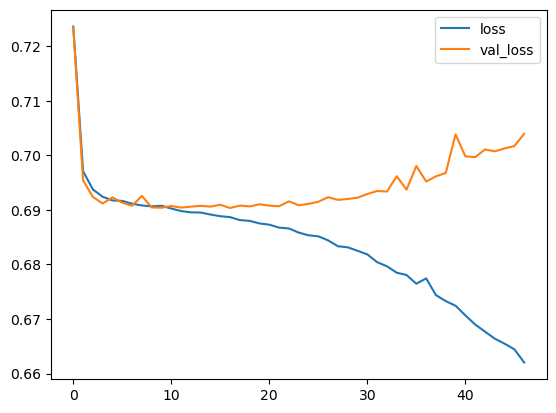

In [32]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

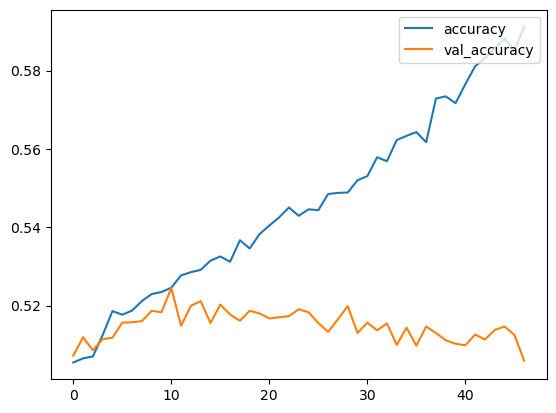

In [33]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [34]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [35]:
bkg_sr_jet_1 = np.load('background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('background_images_sr_25_jet_2.npy')

signal_sr_jet_1 = np.load('dd10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('dd10_sr_25_jet_2.npy')



In [36]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [37]:
x_predict = cwola_ft.predict([x_test_1, x_test_2])


In [38]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]

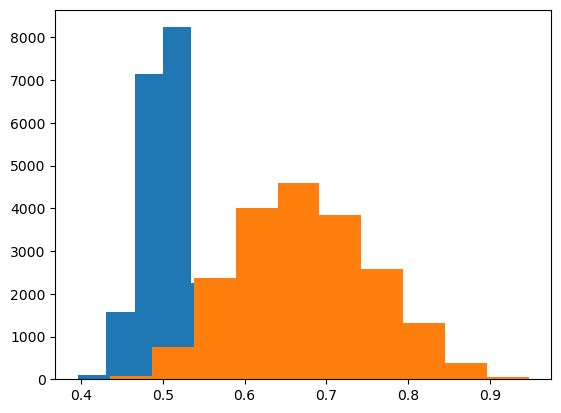

In [39]:
plt.hist(x_predict_0)
plt.hist(x_predict_1)
plt.show()

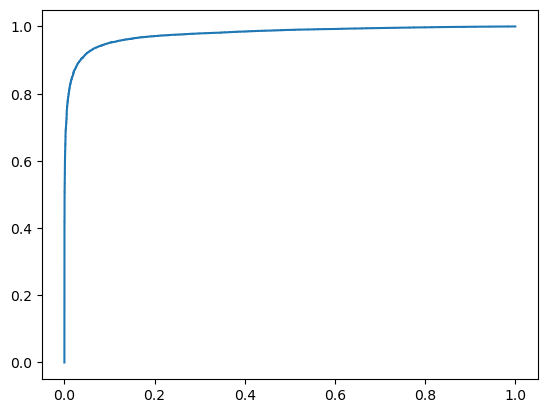

0.9780888575


In [40]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [42]:
print(cwola_ft.layers[4].weights)

[<tf.Variable 'shift:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'scale:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'sequential_24/conv_scale_shift_48/conv2d_48/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
array([[[[ 0.01114146, -0.00054175,  0.02771809, ...,  0.00644149,
           0.00301851, -0.04814416]],

        [[-0.00246558, -0.02887559,  0.0596197 , ...,  0.02131684

In [46]:
print(cwola_ft.layers[5].weights)

[<tf.Variable 'sequential_25/dense_48/kernel:0' shape=(1152, 128) dtype=float32, numpy=
array([[ 0.01691067,  0.06113958,  0.0239291 , ...,  0.05562135,
        -0.01317509,  0.02676301],
       [ 0.02367187, -0.04429162,  0.03687891, ..., -0.0780828 ,
        -0.04628127,  0.05784649],
       [ 0.02862363, -0.03191993, -0.01491416, ..., -0.05456154,
         0.0273072 ,  0.05877329],
       ...,
       [-0.06536918, -0.03946484, -0.06102525, ...,  0.03274387,
        -0.04988235,  0.05883904],
       [ 0.04754862,  0.03669136,  0.04205898, ..., -0.05281666,
        -0.04370595, -0.06297372],
       [ 0.06695219,  0.03747988, -0.06529211, ..., -0.02146034,
         0.00288754, -0.02958223]], dtype=float32)>, <tf.Variable 'sequential_25/dense_48/bias:0' shape=(128,) dtype=float32, numpy=
array([ 0.01629911,  0.00114826,  0.01629598,  0.01661697,  0.01387834,
        0.00852005,  0.0164494 ,  0.01258347,  0.01578439,  0.00473136,
        0.02196059, -0.01258575,  0.0120132 ,  0.01125494,

In [47]:
print(epsilon_s)

[0.5663  0.8046  0.95115]


In [48]:
n_train_sr_signal = 500

In [49]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[2]+25000*0.1)*np.log(n_train_sr_signal*epsilon_s[2]/(25000*0.1) + 1) - 
                 n_train_sr_signal*epsilon_s[2])))

9.231594380980093
